# Import necessary modules

In [1]:
%pip install -U -q neurograd["all"]
%pip install -U -q cupy-cuda12x
# %pip install -q scalene==1.5.20
%pip install -q scalene==1.5.50

%reload_ext scalene
import neurograd as ng
import os
import numpy as np
import gzip
import urllib.request

try:
    import cupy as cp
    # Clear all device memory
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
    cp.cuda.runtime.deviceSynchronize()
except ImportError:
    print("[INFO] CuPy not found – using NumPy (CPU) for the demo.")
    import numpy as cp

from matplotlib import pyplot as plt
import random

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


# Prepare tiny ImageNet

In [2]:
# ================================================
# Tiny-ImageNet-200: download, extract, restructure,
# map WNIDs to words, then use ImageFolder + DataLoader
# ================================================
import os, zipfile, urllib.request, shutil
from pathlib import Path
import neurograd
from neurograd import Tensor, xp
from neurograd.utils.data import ImageFolder, DataLoader
import albumentations as A

# -------- config --------
DATA_DIR = Path("./data")
ZIP_PATH = DATA_DIR / "tiny-imagenet-200.zip"
ROOT     = DATA_DIR / "tiny-imagenet-200"
TRAIN    = ROOT / "train"
VAL      = ROOT / "val"
VAL_IMG  = VAL / "images"
VAL_ANN  = VAL / "val_annotations.txt"
WORDS_TXT = ROOT / "words.txt"

URLS = [
    "http://cs231n.stanford.edu/tiny-imagenet-200.zip",
    "https://tiny-imagenet.s3.amazonaws.com/tiny-imagenet-200.zip",  # fallback
]

BATCH_SIZE   = 256
IMG_SHAPE    = (227, 227)
IMG_MODE     = "RGB"
USE_ONE_HOT  = True
NUM_CLASSES  = 200

# -------- helpers --------
def download_with_fallback(urls, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists() and dst.stat().st_size > 0:
        print(f"[SKIP] {dst.name} already present.")
        return
    for url in urls:
        try:
            print(f"[DOWNLOAD] {url}")
            urllib.request.urlretrieve(url, dst)
            print("[OK] Downloaded.")
            return
        except Exception as e:
            print(f"[WARN] Failed: {e}")
    raise RuntimeError("All downloads failed.")

def extract_zip(zip_path: Path, out_dir: Path):
    if out_dir.exists() and (out_dir / "train").exists() and (out_dir / "val").exists():
        print("[SKIP] Already extracted.")
        return
    print(f"[EXTRACT] {zip_path} -> {out_dir.parent}")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(out_dir.parent)
    print("[OK] Extracted.")

def clean_unwanted_directories(base_dir: Path):
    """Remove unwanted directories like .ipynb_checkpoints, .DS_Store, etc."""
    unwanted_patterns = ['.ipynb_checkpoints', '.DS_Store', '__pycache__', 'Thumbs.db']
    removed_count = 0
    
    for pattern in unwanted_patterns:
        for path in base_dir.glob(f"**/{pattern}"):
            if path.is_dir():
                shutil.rmtree(path)
                print(f"[CLEAN] Removed directory: {path}")
                removed_count += 1
            elif path.is_file():
                path.unlink()
                print(f"[CLEAN] Removed file: {path}")
                removed_count += 1
    
    if removed_count > 0:
        print(f"[OK] Cleaned {removed_count} unwanted items.")
    return removed_count

def is_valid_wnid(directory_name: str):
    """Check if directory name looks like a valid WNID (starts with 'n' followed by 8 digits)"""
    parts = directory_name.split('_')
    wnid = parts[0]
    return (len(wnid) == 9 and 
            wnid.startswith('n') and 
            wnid[1:].isdigit())

def restructure_train_inplace(train_dir: Path):
    # First clean unwanted directories
    clean_unwanted_directories(train_dir)
    
    valid_dirs = []
    for wnid in [p for p in train_dir.iterdir() if p.is_dir()]:
        if is_valid_wnid(wnid.name):
            valid_dirs.append(wnid)
            images_dir = wnid / "images"
            if images_dir.is_dir():
                for img in images_dir.iterdir():
                    if img.is_file():
                        os.replace(img, wnid / img.name)
                try:
                    images_dir.rmdir()
                except OSError:
                    pass
        else:
            print(f"[WARN] Removing invalid directory: {wnid.name}")
            if wnid.is_dir():
                shutil.rmtree(wnid)
            else:
                wnid.unlink()
    
    print(f"[TRAIN] Restructured. Found {len(valid_dirs)} valid class directories.")

def restructure_val_inplace(val_dir: Path):
    # First clean unwanted directories
    clean_unwanted_directories(val_dir)
    
    if not (val_dir / "images").exists():
        print("[VAL] Already restructured.")
        return
    
    mapping = {}
    with open(val_dir / "val_annotations.txt", "r") as f:
        for line in f:
            fname, wnid = line.strip().split("\t")[:2]
            if is_valid_wnid(wnid):
                mapping[fname] = wnid
    
    valid_classes = set()
    for fname, wnid in mapping.items():
        src = val_dir / "images" / fname
        if src.exists():
            dst_dir = val_dir / wnid
            dst_dir.mkdir(parents=True, exist_ok=True)
            os.replace(src, dst_dir / fname)
            valid_classes.add(wnid)
    
    try:
        (val_dir / "images").rmdir()
    except OSError:
        pass
    
    print(f"[VAL] Restructured. Found {len(valid_classes)} valid class directories.")

def load_wnid_to_words(words_file: Path):
    wnid_to_words = {}
    if not words_file.exists():
        print(f"[WARN] {words_file} not found. Using WNIDs as class names.")
        return wnid_to_words
    with open(words_file, "r") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 2:
                wnid = parts[0]
                # Only include valid WNIDs that are actually used in Tiny-ImageNet-200
                if is_valid_wnid(wnid):
                    words = parts[1].split(",")[0].strip()
                    wnid_to_words[wnid] = words
    print(f"[OK] Loaded {len(wnid_to_words)} WNID->words mappings.")
    return wnid_to_words

def rename_directories_to_words(base_dir: Path, wnid_to_words: dict):
    if not wnid_to_words:
        print("[SKIP] No WNID mappings available.")
        return {}
    
    wnid_to_new_name, renamed_count = {}, 0
    valid_dirs = [p for p in base_dir.iterdir() if p.is_dir() and is_valid_wnid(p.name)]
    
    for wnid_dir in valid_dirs:
        wnid = wnid_dir.name.split('_')[0]  # Get the WNID part
        if wnid in wnid_to_words:
            clean_word = "".join(c if c.isalnum() else "_" for c in wnid_to_words[wnid]).strip("_")
            new_name = f"{wnid}_{clean_word}"
            new_dir = base_dir / new_name
            if not wnid_dir.name.endswith(f"_{clean_word}"):
                try:
                    wnid_dir.rename(new_dir)
                    wnid_to_new_name[wnid] = new_name
                    renamed_count += 1
                except OSError as e:
                    print(f"[WARN] Could not rename {wnid}: {e}")
                    wnid_to_new_name[wnid] = wnid_dir.name
            else:
                wnid_to_new_name[wnid] = wnid_dir.name
        else:
            wnid_to_new_name[wnid] = wnid_dir.name
    
    print(f"[OK] Renamed {renamed_count} directories with word labels.")
    return wnid_to_new_name

def verify_class_count(base_dir: Path, expected_count: int = NUM_CLASSES):
    """Verify that we have exactly the expected number of classes"""
    valid_dirs = [p for p in base_dir.iterdir() if p.is_dir() and is_valid_wnid(p.name)]
    actual_count = len(valid_dirs)
    
    print(f"[VERIFY] {base_dir.name}: Expected {expected_count} classes, found {actual_count}")
    
    if actual_count != expected_count:
        print(f"[ERROR] Class count mismatch! Expected {expected_count}, got {actual_count}")
        print("Valid class directories found:")
        for i, d in enumerate(sorted(valid_dirs)[:10]):
            print(f"  {i+1}: {d.name}")
        if len(valid_dirs) > 10:
            print(f"  ... and {len(valid_dirs) - 10} more")
        return False
    return True

# -------- run prep --------
download_with_fallback(URLS, ZIP_PATH)
extract_zip(ZIP_PATH, ROOT)
restructure_train_inplace(TRAIN)
restructure_val_inplace(VAL)

# Verify class counts before proceeding
train_valid = verify_class_count(TRAIN, NUM_CLASSES)
val_valid = verify_class_count(VAL, NUM_CLASSES)

if not (train_valid and val_valid):
    print("[ERROR] Invalid class structure detected. Please check your data.")
    exit(1)

# -------- load wnid mappings and rename directories --------
wnid_to_words = load_wnid_to_words(WORDS_TXT)
train_mapping = rename_directories_to_words(TRAIN, wnid_to_words)
val_mapping = rename_directories_to_words(VAL, wnid_to_words)

# -------- one-hot transform --------
def to_one_hot(idx: int, num_classes: int = NUM_CLASSES):
    v = xp.zeros((num_classes,), dtype=xp.float32)
    v[idx] = 1.0
    return v

target_tf = (lambda i: to_one_hot(i, NUM_CLASSES)) if USE_ONE_HOT else None
target_dtype = xp.float32 if USE_ONE_HOT else xp.int64

# -------- augmentations/datasets/loaders --------
train_aug = A.Compose([
    # geometry
    A.RandomResizedCrop(
        size=IMG_SHAPE,                   # (H, W)
        scale=(0.5, 1.0),
        ratio=(3/4, 4/3),
        p=1.0
    ),
    A.HorizontalFlip(p=0.5),
    A.Affine(
        translate_percent=(0.08, 0.08),
        scale=(0.85, 1.15),
        rotate=(-15, 15),
        shear=(-8, 8),
        fit_output=False,
        fill=0,                           # <- was cval
        p=0.7
    ),

    # photometric
    A.OneOf([
        A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05, p=1.0),
        A.HueSaturationValue(hue_shift_limit=12, sat_shift_limit=20, val_shift_limit=12, p=1.0),
    ], p=0.9),
    A.RandomGamma(gamma_limit=(70, 130), p=0.2),
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.2),

    # blur/noise (light)
    A.OneOf([
        A.MotionBlur(blur_limit=5, p=1.0),
        A.MedianBlur(blur_limit=3, p=1.0),
        A.GaussNoise(std_range=(0.05, 0.15), mean_range=(0.0, 0.0), p=1.0),  # <- was var_limit/mean
    ], p=0.25),

    # occlusion
    A.CoarseDropout(
        num_holes_range=(1, 3),                     # <- was min_holes/max_holes
        hole_height_range=(0.06, 0.18),             # <- was min_height/max_height
        hole_width_range=(0.06, 0.18),              # <- was min_width/max_width
        fill=0,                                     # <- was fill_value
        p=0.7
    ),
])

train_ds = ImageFolder(
    root=str(TRAIN),
    img_shape=IMG_SHAPE,
    img_mode=IMG_MODE,
    img_normalize=True,
    img_transform=train_aug,
    target_transform=target_tf,
    img_dtype=xp.float32,
    target_dtype=target_dtype,
    chw=True,
)

val_ds = ImageFolder(
    root=str(VAL),
    img_shape=IMG_SHAPE,
    img_mode=IMG_MODE,
    img_normalize=True,
    target_transform=target_tf,
    img_dtype=xp.float32,
    target_dtype=target_dtype,
    chw=True,
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, seed=42)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

# -------- sanity check --------
Xb, yb = next(iter(train_loader))
print("\nTiny-ImageNet batch:")
print("X:", Xb.shape, Xb.dtype)
print("y:", yb.shape, yb.dtype)

# Show class folder names (should now be exactly 200)
class_folders = sorted([d for d in os.listdir(TRAIN) if os.path.isdir(os.path.join(TRAIN, d)) and is_valid_wnid(d)])
print(f"\nTotal valid class folders: {len(class_folders)}")
print("Sample class folder names:", class_folders[:10])

# Show relevant WNID mappings (only for classes that exist in our dataset)
if wnid_to_words:
    relevant_mappings = {wnid: word for wnid, word in wnid_to_words.items() 
                        if any(folder.startswith(wnid) for folder in class_folders)}
    print(f"\nRelevant WNID->words mappings ({len(relevant_mappings)}):")
    for i, (wnid, word) in enumerate(list(relevant_mappings.items())[:10]):
        print(f"  {wnid}: {word}")

TARGET_MAPPING = train_ds.target_mapping
TARGET_INV_MAPPING = {v: k for k, v in TARGET_MAPPING.items()}
TARGET_NAMES = train_ds.target_names

print(f"\nDataset verification:")
print(f"Total classes in dataset: {train_ds.num_classes}")
print(f"Expected classes: {NUM_CLASSES}")
print(f"Match: {'good' if train_ds.num_classes == NUM_CLASSES else 'not good'}")

if train_ds.num_classes == NUM_CLASSES:
    print("First 10 class names:", TARGET_NAMES[:10])
else:
    print("[ERROR] Class count still doesn't match!")
    print("All class names found:", TARGET_NAMES)

[SKIP] tiny-imagenet-200.zip already present.
[SKIP] Already extracted.
[TRAIN] Restructured. Found 200 valid class directories.
[VAL] Already restructured.
[VERIFY] train: Expected 200 classes, found 200
[VERIFY] val: Expected 200 classes, found 200
[OK] Loaded 82115 WNID->words mappings.
[OK] Renamed 91 directories with word labels.
[OK] Renamed 91 directories with word labels.

Tiny-ImageNet batch:
X: (256, 3, 227, 227) <class 'numpy.float32'>
y: (256, 200) <class 'numpy.float32'>

Total valid class folders: 200
Sample class folder names: ['n01443537_goldfish', 'n01629819_European_fire_salamander', 'n01641577_bullfrog', 'n01644900_tailed_frog', 'n01698640_American_alligator', 'n01742172_boa_constrictor', 'n01768244_trilobite', 'n01770393_scorpion', 'n01774384_black_widow', 'n01774750_tarantula']

Relevant WNID->words mappings (200):
  n01443537: goldfish
  n01629819: European fire salamander
  n01641577: bullfrog
  n01644900: tailed frog
  n01698640: American alligator
  n01742172: 

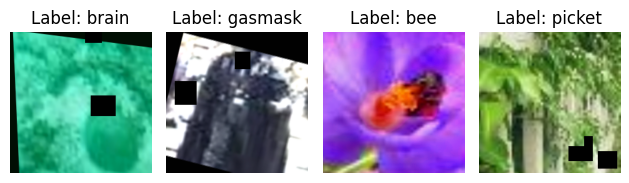

In [3]:
# Plot 4 random images

indices = range(len(train_ds))
chosen = random.sample(indices, 4)

for i, idx in enumerate(chosen, 1):
  plt.subplot(1, 4, i)
  img, label = train_ds[idx]
  img = img.data.transpose(1, 2, 0).get()
  label = TARGET_INV_MAPPING.get(label.data.argmax().item()).split("_")[1]
  plt.axis("off")
  plt.imshow(img)
  plt.title(f"Label: {label}")
plt.tight_layout()
plt.show()

# Model architecture, optimizer and losses

In [4]:
from neurograd.nn.layers import Conv2D, MaxPool2D, Flatten, Linear, Sequential, Dropout

model = Sequential(
    Conv2D(3, 96, 11, strides=4, activation="relu", batch_normalization=True),
    MaxPool2D(3, strides=2),
    Conv2D(96, 256, 5, padding="same", activation="relu", batch_normalization=True),
    MaxPool2D(3, strides=2),
    Conv2D(256, 384, 3, padding="same", activation="relu", batch_normalization=True),
    Conv2D(384, 384, 3, padding="same", activation="relu", batch_normalization=True),
    Conv2D(384, 256, 3, padding="same", activation="relu", batch_normalization=True),
    MaxPool2D(3, strides=2),
    Flatten(),
    Linear(9216, 4096, activation="relu", batch_normalization=True, dropout=0.5),
    Linear(4096, 4096, activation="relu", batch_normalization=True, dropout=0.5),
    Linear(4096, NUM_CLASSES)
)

# model = ng.load("model.pkl")


for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

layer_0.kernels (96, 3, 11, 11)
layer_0.bias (1, 96, 1, 1)
layer_2.kernels (256, 96, 5, 5)
layer_2.bias (1, 256, 1, 1)
layer_4.kernels (384, 256, 3, 3)
layer_4.bias (1, 384, 1, 1)
layer_5.kernels (384, 384, 3, 3)
layer_5.bias (1, 384, 1, 1)
layer_6.kernels (256, 384, 3, 3)
layer_6.bias (1, 256, 1, 1)
layer_9.weight (9216, 4096)
layer_9.bias (4096,)
layer_10.weight (4096, 4096)
layer_10.bias (4096,)
layer_11.weight (4096, 200)
layer_11.bias (200,)


In [5]:
from neurograd.optim import Adam, SGD
from neurograd.nn.losses import CategoricalCrossEntropy
from neurograd.nn.metrics import accuracy_score

optimizer = Adam(model.named_parameters(), lr=1e-3)
loss_fn = CategoricalCrossEntropy(from_logits=True)

# Training (mixed precision)

In [7]:
%%scalene --profile-only neurograd
from tqdm.auto import tqdm
from neurograd.amp import GradScaler
from contextlib import nullcontext

# ======== CONFIG ========
USE_AMP = True  # Toggle mixed precision on/off
EPOCHS = 1
BATCH_SIZE = train_loader.batch_size
# ========================

scaler = GradScaler() if USE_AMP else None

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch: {epoch} / {EPOCHS}:")
    train_losses, train_acc = [], []
    test_losses, test_acc = [], []
    model.train()
    ng.save(model, "model.pkl")
    for (X_train, y_train) in tqdm(train_loader):
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_train)
            loss = loss_fn(y_train, y_pred)
            # print(loss.data, loss.data.dtype)
            train_losses.append(loss.data)
            optimizer.zero_grad()
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            acc = accuracy_score(y_train.argmax(axis=-1), y_pred.argmax(axis=-1))
            train_acc.append(acc)

    model.eval()
    for (X_test, y_test) in val_loader:
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_test)
            loss = loss_fn(y_test, y_pred)
            acc = accuracy_score(y_test.argmax(axis=-1), y_pred.argmax(axis=-1))
            test_losses.append(loss.data)
            test_acc.append(acc)

    # Convert lists to arrays before mean
    train_losses = cp.asarray(train_losses)
    train_acc = cp.asarray(train_acc)
    test_losses = cp.asarray(test_losses)
    test_acc = cp.asarray(test_acc)

    print(
        f"Train loss: {cp.nanmean(train_losses):.4f}, "
        f"Train acc: {cp.mean(train_acc):.4f}, "
        f"Test loss: {cp.nanmean(test_losses):.4f}, "
        f"Test acc: {cp.mean(test_acc):.4f}"
    )

Epoch: 1 / 1:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 4.7973, Train acc: 0.0594, Test loss: 4.8537, Test acc: 0.0599


In [ ]:
from tqdm.auto import tqdm
from neurograd.amp import GradScaler
from contextlib import nullcontext

# ======== CONFIG ========
USE_AMP = True  # Toggle mixed precision on/off
EPOCHS = 100
BATCH_SIZE = train_loader.batch_size
# ========================

scaler = GradScaler() if USE_AMP else None

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch: {epoch} / {EPOCHS}:")
    train_losses, train_acc = [], []
    test_losses, test_acc = [], []
    model.train()
    ng.save(model, "model.pkl")
    for (X_train, y_train) in tqdm(train_loader):
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_train)
            loss = loss_fn(y_train, y_pred)
            # print(loss.data, loss.data.dtype)
            train_losses.append(loss.data)
            optimizer.zero_grad()
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            acc = accuracy_score(y_train.argmax(axis=-1), y_pred.argmax(axis=-1))
            train_acc.append(acc)

    model.eval()
    for (X_test, y_test) in val_loader:
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_test)
            loss = loss_fn(y_test, y_pred)
            acc = accuracy_score(y_test.argmax(axis=-1), y_pred.argmax(axis=-1))
            test_losses.append(loss.data)
            test_acc.append(acc)

    # Convert lists to arrays before mean
    train_losses = cp.asarray(train_losses)
    train_acc = cp.asarray(train_acc)
    test_losses = cp.asarray(test_losses)
    test_acc = cp.asarray(test_acc)

    print(
        f"Train loss: {cp.nanmean(train_losses):.4f}, "
        f"Train acc: {cp.mean(train_acc):.4f}, "
        f"Test loss: {cp.nanmean(test_losses):.4f}, "
        f"Test acc: {cp.mean(test_acc):.4f}"
    )

Epoch: 1 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.9142, Train acc: 0.1671, Test loss: 3.9395, Test acc: 0.1828
Epoch: 2 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.8728, Train acc: 0.1729, Test loss: 3.8275, Test acc: 0.1771
Epoch: 3 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.8533, Train acc: 0.1755, Test loss: 3.6859, Test acc: 0.2034
Epoch: 4 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.7766, Train acc: 0.1856, Test loss: 3.6350, Test acc: 0.2137
Epoch: 5 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.7551, Train acc: 0.1905, Test loss: 4.0971, Test acc: 0.1670
Epoch: 6 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.7119, Train acc: 0.1979, Test loss: 3.6118, Test acc: 0.2184
Epoch: 7 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.6781, Train acc: 0.2022, Test loss: 3.5867, Test acc: 0.2197
Epoch: 8 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.6614, Train acc: 0.2037, Test loss: 3.5208, Test acc: 0.2251
Epoch: 9 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.6340, Train acc: 0.2092, Test loss: 3.4852, Test acc: 0.2368
Epoch: 10 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.6179, Train acc: 0.2119, Test loss: 3.4492, Test acc: 0.2398
Epoch: 11 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.5911, Train acc: 0.2158, Test loss: 3.4385, Test acc: 0.2409
Epoch: 12 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.5657, Train acc: 0.2179, Test loss: 3.4768, Test acc: 0.2407
Epoch: 13 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.5554, Train acc: 0.2214, Test loss: 3.3194, Test acc: 0.2631
Epoch: 14 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

In [ ]:
from tqdm.auto import tqdm
from neurograd.amp import GradScaler
from contextlib import nullcontext

# ======== CONFIG ========
USE_AMP = True  # Toggle mixed precision on/off
EPOCHS = 100
BATCH_SIZE = train_loader.batch_size
# ========================

scaler = GradScaler() if USE_AMP else None

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch: {epoch} / {EPOCHS}:")
    train_losses, train_acc = [], []
    test_losses, test_acc = [], []
    model.train()
    ng.save(model, "model.pkl")
    for (X_train, y_train) in tqdm(train_loader):
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_train)
            loss = loss_fn(y_train, y_pred)
            # print(loss.data, loss.data.dtype)
            train_losses.append(loss.data)
            optimizer.zero_grad()
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            acc = accuracy_score(y_train.argmax(axis=-1), y_pred.argmax(axis=-1))
            train_acc.append(acc)

    model.eval()
    for (X_test, y_test) in val_loader:
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_test)
            loss = loss_fn(y_test, y_pred)
            acc = accuracy_score(y_test.argmax(axis=-1), y_pred.argmax(axis=-1))
            test_losses.append(loss.data)
            test_acc.append(acc)

    # Convert lists to arrays before mean
    train_losses = cp.asarray(train_losses)
    train_acc = cp.asarray(train_acc)
    test_losses = cp.asarray(test_losses)
    test_acc = cp.asarray(test_acc)

    print(
        f"Train loss: {cp.nanmean(train_losses):.4f}, "
        f"Train acc: {cp.mean(train_acc):.4f}, "
        f"Test loss: {cp.nanmean(test_losses):.4f}, "
        f"Test acc: {cp.mean(test_acc):.4f}"
    )

Epoch: 1 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.5104, Train acc: 0.2292, Test loss: 3.7330, Test acc: 0.2070
Epoch: 2 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.5001, Train acc: 0.2298, Test loss: 3.2780, Test acc: 0.2703
Epoch: 3 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.4816, Train acc: 0.2315, Test loss: 3.3268, Test acc: 0.2621
Epoch: 4 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.4399, Train acc: 0.2388, Test loss: 3.3912, Test acc: 0.2522
Epoch: 5 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.4005, Train acc: 0.2447, Test loss: 3.2910, Test acc: 0.2715
Epoch: 6 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.3675, Train acc: 0.2492, Test loss: 3.5345, Test acc: 0.2297
Epoch: 7 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.3406, Train acc: 0.2547, Test loss: 4.0051, Test acc: 0.1912
Epoch: 8 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.3198, Train acc: 0.2557, Test loss: 3.2980, Test acc: 0.2656
Epoch: 9 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.3008, Train acc: 0.2624, Test loss: 3.2458, Test acc: 0.2733
Epoch: 10 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.3128, Train acc: 0.2582, Test loss: 3.2763, Test acc: 0.2697
Epoch: 11 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.3292, Train acc: 0.2562, Test loss: 3.4091, Test acc: 0.2548
Epoch: 12 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.3206, Train acc: 0.2575, Test loss: 3.4236, Test acc: 0.2469
Epoch: 13 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.2934, Train acc: 0.2608, Test loss: 3.3013, Test acc: 0.2709
Epoch: 14 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

In [ ]:
from tqdm.auto import tqdm
from neurograd.amp import GradScaler
from contextlib import nullcontext

# ======== CONFIG ========
USE_AMP = True  # Toggle mixed precision on/off
EPOCHS = 100
BATCH_SIZE = train_loader.batch_size
# ========================

scaler = GradScaler() if USE_AMP else None

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch: {epoch} / {EPOCHS}:")
    train_losses, train_acc = [], []
    test_losses, test_acc = [], []
    model.train()
    ng.save(model, "model.pkl")
    for (X_train, y_train) in tqdm(train_loader):
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_train)
            loss = loss_fn(y_train, y_pred)
            # print(loss.data, loss.data.dtype)
            train_losses.append(loss.data)
            optimizer.zero_grad()
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            acc = accuracy_score(y_train.argmax(axis=-1), y_pred.argmax(axis=-1))
            train_acc.append(acc)

    model.eval()
    for (X_test, y_test) in val_loader:
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_test)
            loss = loss_fn(y_test, y_pred)
            acc = accuracy_score(y_test.argmax(axis=-1), y_pred.argmax(axis=-1))
            test_losses.append(loss.data)
            test_acc.append(acc)

    # Convert lists to arrays before mean
    train_losses = cp.asarray(train_losses)
    train_acc = cp.asarray(train_acc)
    test_losses = cp.asarray(test_losses)
    test_acc = cp.asarray(test_acc)

    print(
        f"Train loss: {cp.nanmean(train_losses):.4f}, "
        f"Train acc: {cp.mean(train_acc):.4f}, "
        f"Test loss: {cp.nanmean(test_losses):.4f}, "
        f"Test acc: {cp.mean(test_acc):.4f}"
    )

Epoch: 1 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.2895, Train acc: 0.2631, Test loss: 3.2389, Test acc: 0.2833
Epoch: 2 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.2776, Train acc: 0.2645, Test loss: 3.4055, Test acc: 0.2558
Epoch: 3 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.2815, Train acc: 0.2613, Test loss: 3.3960, Test acc: 0.2568
Epoch: 4 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.2846, Train acc: 0.2634, Test loss: 3.9367, Test acc: 0.1970
Epoch: 5 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.2712, Train acc: 0.2639, Test loss: 3.5248, Test acc: 0.2385
Epoch: 6 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.2553, Train acc: 0.2676, Test loss: 3.5985, Test acc: 0.2309
Epoch: 7 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.3681, Train acc: 0.2569, Test loss: 3.4458, Test acc: 0.2514
Epoch: 8 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.3009, Train acc: 0.2657, Test loss: 3.0846, Test acc: 0.3075
Epoch: 9 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.2176, Train acc: 0.2740, Test loss: 4.1081, Test acc: 0.1745
Epoch: 10 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.2020, Train acc: 0.2773, Test loss: 3.1296, Test acc: 0.3112
Epoch: 11 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.1937, Train acc: 0.2765, Test loss: 3.4536, Test acc: 0.2500
Epoch: 12 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.1951, Train acc: 0.2785, Test loss: 3.1917, Test acc: 0.2894
Epoch: 13 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.1776, Train acc: 0.2787, Test loss: 3.6526, Test acc: 0.2245
Epoch: 14 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.1566, Train acc: 0.2860, Test loss: 3.1724, Test acc: 0.2986
Epoch: 15 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.1310, Train acc: 0.2888, Test loss: 3.2148, Test acc: 0.2910
Epoch: 16 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.1505, Train acc: 0.2849, Test loss: 3.5570, Test acc: 0.2437
Epoch: 17 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.1306, Train acc: 0.2885, Test loss: 3.3880, Test acc: 0.2627
Epoch: 18 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.1464, Train acc: 0.2857, Test loss: 4.4514, Test acc: 0.1501
Epoch: 19 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.1374, Train acc: 0.2862, Test loss: 3.7048, Test acc: 0.2183
Epoch: 20 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.1159, Train acc: 0.2900, Test loss: 3.8858, Test acc: 0.2065
Epoch: 21 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0996, Train acc: 0.2936, Test loss: 3.9575, Test acc: 0.1997
Epoch: 22 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0874, Train acc: 0.2950, Test loss: 3.1467, Test acc: 0.3029
Epoch: 23 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

In [6]:
from tqdm.auto import tqdm
from neurograd.amp import GradScaler
from contextlib import nullcontext

# ======== CONFIG ========
USE_AMP = True  # Toggle mixed precision on/off
EPOCHS = 100
BATCH_SIZE = train_loader.batch_size
# ========================

scaler = GradScaler() if USE_AMP else None

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch: {epoch} / {EPOCHS}:")
    train_losses, train_acc = [], []
    test_losses, test_acc = [], []
    model.train()
    ng.save(model, "model.pkl")
    for (X_train, y_train) in tqdm(train_loader):
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_train)
            loss = loss_fn(y_train, y_pred)
            # print(loss.data, loss.data.dtype)
            train_losses.append(loss.data)
            optimizer.zero_grad()
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            acc = accuracy_score(y_train.argmax(axis=-1), y_pred.argmax(axis=-1))
            train_acc.append(acc)

    model.eval()
    for (X_test, y_test) in val_loader:
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_test)
            loss = loss_fn(y_test, y_pred)
            acc = accuracy_score(y_test.argmax(axis=-1), y_pred.argmax(axis=-1))
            test_losses.append(loss.data)
            test_acc.append(acc)

    # Convert lists to arrays before mean
    train_losses = cp.asarray(train_losses)
    train_acc = cp.asarray(train_acc)
    test_losses = cp.asarray(test_losses)
    test_acc = cp.asarray(test_acc)

    print(
        f"Train loss: {cp.nanmean(train_losses):.4f}, "
        f"Train acc: {cp.mean(train_acc):.4f}, "
        f"Test loss: {cp.nanmean(test_losses):.4f}, "
        f"Test acc: {cp.mean(test_acc):.4f}"
    )

Epoch: 1 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0542, Train acc: 0.3021, Test loss: 3.4602, Test acc: 0.2511
Epoch: 2 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0540, Train acc: 0.3030, Test loss: 3.1037, Test acc: 0.3060
Epoch: 3 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0433, Train acc: 0.3030, Test loss: 3.1948, Test acc: 0.2940
Epoch: 4 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0663, Train acc: 0.2991, Test loss: 3.5023, Test acc: 0.2476
Epoch: 5 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0667, Train acc: 0.2989, Test loss: 3.6296, Test acc: 0.2351
Epoch: 6 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0929, Train acc: 0.2945, Test loss: 3.4269, Test acc: 0.2577
Epoch: 7 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0758, Train acc: 0.2959, Test loss: 3.3998, Test acc: 0.2689
Epoch: 8 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0854, Train acc: 0.2955, Test loss: 3.2850, Test acc: 0.2888
Epoch: 9 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.0673, Train acc: 0.2980, Test loss: 3.0969, Test acc: 0.3131
Epoch: 10 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: 3.1157, Train acc: 0.2885, Test loss: 3.2552, Test acc: 0.2872
Epoch: 11 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
%%scalene

from tqdm.auto import tqdm
from neurograd.amp import GradScaler
from contextlib import nullcontext

# ======== CONFIG ========
USE_AMP = True  # Toggle mixed precision on/off
EPOCHS = 1
BATCH_SIZE = train_loader.batch_size
# ========================

scaler = GradScaler() if USE_AMP else None

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch: {epoch} / {EPOCHS}:")
    train_losses, train_acc = [], []
    test_losses, test_acc = [], []
    model.train()
    ng.save(model, "model.pkl")
    for (X_train, y_train) in tqdm(train_loader):
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_train)
            loss = loss_fn(y_train, y_pred)
            # print(loss.data, loss.data.dtype)
            train_losses.append(loss.data)
            optimizer.zero_grad()
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            acc = accuracy_score(y_train.argmax(axis=-1), y_pred.argmax(axis=-1))
            train_acc.append(acc)

    model.eval()
    for (X_test, y_test) in val_loader:
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_test)
            loss = loss_fn(y_test, y_pred)
            acc = accuracy_score(y_test.argmax(axis=-1), y_pred.argmax(axis=-1))
            test_losses.append(loss.data)
            test_acc.append(acc)

    # Convert lists to arrays before mean
    train_losses = cp.asarray(train_losses)
    train_acc = cp.asarray(train_acc)
    test_losses = cp.asarray(test_losses)
    test_acc = cp.asarray(test_acc)

    print(
        f"Train loss: {cp.nanmean(train_losses):.4f}, "
        f"Train acc: {cp.mean(train_acc):.4f}, "
        f"Test loss: {cp.nanmean(test_losses):.4f}, "
        f"Test acc: {cp.mean(test_acc):.4f}"
    )

Epoch: 1 / 1:


# Visualize model predictions

In [ ]:
# Plot 4 random predictions from validation set
X, y = random.choice(val_loader)

with ng.autocast():
    y_pred = model(X)

indices = range(len(X))
chosen = random.sample(indices, 4)

correct = 0
for i, idx in enumerate(chosen, 1):
    plt.subplot(1, 4, i)
    img = X[idx].data.transpose(1, 2, 0).get()  # Convert CHW to HWC

    if USE_ONE_HOT:
        label = y[idx].data.argmax(-1).item()
        pred = y_pred[idx].data.argmax(-1).item()
    else:
        label = y[idx].data.item()
        pred = y_pred[idx].data.argmax(-1).item()

    correct += (label == pred)

    # Get human-readable class names
    label_name = TARGET_NAMES[label] if label < len(TARGET_NAMES) else str(label)
    pred_name = TARGET_NAMES[pred] if pred < len(TARGET_NAMES) else str(pred)

    plt.axis("off")
    plt.imshow(img)
    plt.title(f"Label: {label_name}\nPred: {pred_name}")

plt.tight_layout()
plt.show()
print(f"Guessed {correct} / 4")